In [20]:
import json
import sys
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, loguniform
from math import lgamma
from glob import glob
import os
from ast import literal_eval, parse
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/chrislam/Desktop/sculpting/'

In [2]:
def better_loglike(lam, k):
	"""
	Calculate Poisson log likelihood
	Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf

	Params: 
	- lam: model predictions for transit multiplicity (list of ints)
	- k: Kepler transit multiplicity (list of ints); can accept alternate ground truths as well

	Returns: Poisson log likelihood (float)
	"""

	logL = []
	#print(lam)
	for i in range(len(lam)):
		if lam[i]==0:
			term3 = -lgamma(k[i]+1)
			term2 = -lam[i]
			term1 = 0
			logL.append(term1+term2+term3)

		else:
			term3 = -lgamma(k[i]+1)
			term2 = -lam[i]
			term1 = k[i]*np.log(lam[i])
			logL.append(term1+term2+term3)

	return np.sum(logL)

berger_kepler = pd.read_csv(path+'berger_kepler_stellar_fgk.csv') # crossmatched with Gaia via Bedell
pnum = pd.read_csv(path+'pnum_plus_cands_fgk.csv')
pnum = pnum.drop_duplicates(['kepid'])
k = pnum.koi_count.value_counts() 
#k = pd.Series([len(berger_kepler)-np.sum(k), 244, 51, 12, 8, 1, 0]) 
k = pd.Series([len(berger_kepler)-np.sum(k), 833, 134, 38, 15, 5])
k = pd.Series([833, 134, 38, 15, 5, 0])
print("k: ", k)

k:  0    833
1    134
2     38
3     15
4      5
5      0
dtype: int64


/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
### USE THIS ONE OR THE ONE IN MY PAPER??
pnum_young = pnum.loc[pnum.iso_age <= 1]
pnum_old = pnum.loc[pnum.iso_age > 1]
k_young = pnum_young.koi_count.value_counts() 
k_old = pnum_old.koi_count.value_counts() 
print(k_young)
print(k_old)
#print(transit_multiplicity_young)
#print(transit_multiplicity_old)


2    4
1    3
Name: koi_count, dtype: int64
1    802
2    155
3     37
4     18
5      6
Name: koi_count, dtype: int64


### Why do some transit files have more columns than others?

In [320]:
df = pd.read_csv('transits0_1_3_6.csv')
#print(df.head())
print(df.columns)
df = pd.read_csv('transits0_1_3_7.csv', names=list(range(253)))
#print(df.head())
print(df.columns)

/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (139) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['Unnamed: 0', 'kepid', 'tm_designation', 'teff', 'teff_err1',
       'teff_err2', 'logg', 'logg_err1', 'logg_err2', 'feh_x',
       ...
       'intact_flag', 'num_planets', 'ecc', 'incl', 'omega', 'planet_radius',
       'mutual_incl', 'transit_status', 'prob_detections', 'sn'],
      dtype='object', length=156)


/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,32,33,34,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,139,140,141,142,143,144,147,148,149,150,151,152,153,154,155,156,157,158,159,162,163,164,165,169,178,179,183,184,185,192,196,197,204,208,209,219,223,224,238,241,242,243,245,246) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            243, 244, 245, 246, 247, 248, 249, 250, 251, 252],
           dtype='int64', length=253)


### Actually start logL analysis

In [137]:
#https://stackoverflow.com/questions/52232742/how-to-use-ast-literal-eval-in-a-pandas-dataframe-and-handle-exceptions
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        #print(e)
        pass
    
def float_w_exceptions(x):
    try:
        return float(x)   
    except Exception as e:
        #print(e)
        pass
    
#df.transit_multiplicity = df.transit_multiplicity.apply(lambda x: literal_eval_w_exceptions(x))

In [165]:
"""
df = pd.read_csv('logLs_incremental.txt', sep='\t',
                 usecols=['filename','m','b','c','f','logL','transit_multiplicity','intact_frac',
                                                                        'disrupted_frac'],
                dtype={'filename': str, 'm': np.float64, 'b': np.float64, 'c': np.float64,
                      'f': np.float64, 'logL': np.float64, 'transit_multiplicity': str,
                       'intact_frac': np.float64, 'disrupted_frac': np.float64})
"""
df = pd.read_csv('logLs_incremental.txt', sep='\t', error_bad_lines=False,
                 usecols=['filename','m','b','c','f','logL','transit_multiplicity','intact_frac',
                                                                        'disrupted_frac'], dtype=str)
#print(df.head())
#print(df.columns)
print(df.transit_multiplicity)
print(df.transit_multiplicity[0])
#print(df.logL)

df.transit_multiplicity = df.transit_multiplicity.apply(literal_eval_w_exceptions) # convert back from string to list of floats
#df.transit_multiplicity = df.transit_multiplicity.apply(lambda y: np.nan if len(y)==0 else y)
#df.logL = df.logL.apply(str) # convert back from string to list of floats
df.logL = df.logL.apply(float_w_exceptions) # convert back from string to list of floats
df.m = df.m.apply(float_w_exceptions) # convert back from string to list of floats
df.b = df.b.apply(float_w_exceptions) # convert back from string to list of floats
df.c = df.c.apply(float_w_exceptions) # convert back from string to list of floats
df.f = df.f.apply(float_w_exceptions) # convert back from string to list of floats
df.intact_frac = df.intact_frac.apply(float_w_exceptions) # convert back from string to list of floats
df.disrupted_frac = df.disrupted_frac.apply(float_w_exceptions) # convert back from string to list of floats

#df.transit_multiplicity = df.transit_multiplicity.apply(literal_eval) # convert back from string to list of floats
#df.transit_multiplicity = df.transit_multiplicity.apply(lambda y: np.nan if len(y)==0 else y)
#print(len(df))
#print(df.m.unique())

# take mean logL
mean_df = df.groupby(['filename', 'f']).mean('logL')
#print(mean_df)
# groupby-mean doesn't work with lists, so separately take care of that
list_df = df.groupby(['filename', 'f']).transit_multiplicity.apply(list)
#print(list_df)
# recombine to same DataFrame
mean_df['transit_multiplicity'] = list_df
mean_df.reset_index(inplace=True)
#print(mean_df.head())
#print(mean_df.f)

try_df = mean_df.loc[(mean_df.f==0.2)&(mean_df.c<1e9+1)&(df.c>1e9-1)]
print(try_df)
#print(try_df.m.unique())
# what about the good one?
#print(df.loc[(df.m==-0.2)&(df.b==0.4)&(df.c<4e9)&(df.c>3e9)])

0                                                [0.0, 0.0]
1                                                [0.0, 0.0]
2                                                [0.0, 0.0]
3                                                [0.0, 0.0]
4                                                [0.0, 0.0]
                                ...                        
563828    [2277.9, 1598.4, 1112.4, 762.3000000000001, 36...
563829    [2264.4, 1539.0, 1152.9, 797.4, 366.3, 66.6000...
563830         [2612.0, 1717.0, 1259.0, 816.0, 430.0, 86.0]
563831         [2531.0, 1776.0, 1236.0, 847.0, 409.0, 91.0]
563832         [2516.0, 1710.0, 1281.0, 886.0, 407.0, 74.0]
Name: transit_multiplicity, Length: 563833, dtype: object
[0.0, 0.0]
                                                filename    f    m    b  \
563    /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  0.0   
574    /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  0.0   
585    /blue/sarahballard/c.lam/sculpting2/sim

In [140]:
# redo ms because I forgot that I rounded to single decimal beforehand
ms_corrected = []
ms_corrected_for_plotting = []
for gi_m in range(11):
    for gi_b in range(11):
        ms = -1e-9*np.logspace(8,10,11)[gi_m]
        ms_corrected.append(ms)
        ms_for_plotting = np.log10(np.logspace(8,10,11))[gi_m]
        ms_corrected_for_plotting.append(ms_for_plotting)
print(ms_corrected)
print(ms_corrected_for_plotting)

[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944

In [142]:
df.c.unique()

array([1.00000000e+08, 1.58489319e+08, 2.51188643e+08, 3.98107171e+08,
       6.30957344e+08, 1.00000000e+09, 1.58489319e+09, 2.51188643e+09,
       3.98107171e+09, 6.30957344e+09, 1.00000000e+10,            nan,
       1.23301106e-02, 3.38289399e-01, 4.00000000e-01, 2.35644623e-01])

### Marginalize over cutoffs and fractions

In [166]:
mean_df

,filename,f,m,b,c,logL,intact_frac,disrupted_frac,transit_multiplicity
0,/blue/sarahballard/c.lam/sculpting2/simulation...,0.000000,-2.000000,0.000000e+00,1.000000e+08,-5298.913593,0.000000,0.000000,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
1,/blue/sarahballard/c.lam/sculpting2/simulation...,0.100000,-2.000000,0.000000e+00,1.000000e+08,-241.425817,0.000000,0.099999,"[[412.6, 39.6], [412.6, 39.6], [412.6, 39.6], ..."
2,/blue/sarahballard/c.lam/sculpting2/simulation...,0.200000,-2.000000,0.000000e+00,1.000000e+08,-23.352493,0.000000,0.199998,"[[825.2, 79.2], [825.2, 79.2], [825.2, 79.2], ..."
3,/blue/sarahballard/c.lam/sculpting2/simulation...,0.300000,-2.000000,0.000000e+00,1.000000e+08,-83.467734,0.000000,0.299997,"[[1237.8000000000002, 118.80000000000001], [12..."
4,/blue/sarahballard/c.lam/sculpting2/simulation...,0.400000,-2.000000,0.000000e+00,1.000000e+08,-257.479169,0.000000,0.399996,"[[1650.4, 158.4], [1650.4, 158.4], [1650.4, 15..."
...,...,...,...,...,...,...,...,...,...
57652,/blue/sarahballard/c.lam/sculpting2/simulation...,1.000000,-0.200000,9.000000e-01,6.309573e+09,-3345.550387,0.830676,0.169324,"[[3199.0, 1156.0, 811.0, 493.0, 250.0, 45.0], ..."
57653,0.0,-593.686005,0.500000,1.000000e+10,4.000000e-01,NaN,0.086183,NaN,[0.3138167487852263]
57654,0.30000000000000004,0.064355,-326.382491,NaN,2.356446e-01,NaN,NaN,NaN,[None]
57655,0.4,0.061711,-728.176371,NaN,3.382894e-01,NaN,NaN,NaN,[None]


In [202]:
df.groupby(['ms','bs'], as_index=False).mean('correct_mean_logLs')

,ms,bs,cs,fs,max_logLs,min_logLs,mean_logLs,median_logLs,std_logLs,correct_mean_logLs
0,-2.0,0.0,2.447833e+09,0.5,-42330.860997,-42660.735267,-42525.086954,-42583.664598,142.677588,-1202.969240
1,-2.0,0.1,2.447833e+09,0.5,-42700.052443,-43152.888477,-42866.298970,-42745.955991,203.683542,-1225.885034
2,-2.0,0.2,2.447833e+09,0.5,-42935.161099,-43413.581464,-43173.998381,-43173.252579,196.414631,-1275.835567
3,-2.0,0.3,2.447833e+09,0.5,-43409.505682,-43938.638513,-43656.665541,-43621.852429,224.220875,-1326.460521
4,-2.0,0.4,2.447833e+09,0.5,-43238.524022,-44007.744632,-43565.553310,-43450.391275,337.329564,-1324.263396
...,...,...,...,...,...,...,...,...,...,...
116,0.0,0.6,2.447833e+09,0.5,-46919.897461,-47198.317166,-47055.101857,-47047.090943,114.469300,-1844.530410
117,0.0,0.7,2.447833e+09,0.5,-47895.477342,-48279.558781,-48034.556033,-47928.631976,173.941128,-1999.882759
118,0.0,0.8,2.447833e+09,0.5,-48912.367098,-49810.946883,-49467.391099,-49678.859316,396.238322,-2115.188364
119,0.0,0.9,2.447833e+09,0.5,-50166.168424,-50699.365544,-50438.120904,-50448.828745,217.880690,-2270.456943


In [185]:
df.m = df.m.apply(lambda x: float(("%.1f" % x).rstrip('0').rstrip('.')))
df.b = df.b.apply(lambda x: float(("%.1f" % x).rstrip('0').rstrip('.')))

In [199]:
df.loc[(df.m < -0.79) & (df.m > -0.81)].m

242822   -0.8
242823   -0.8
242824   -0.8
242825   -0.8
242826   -0.8
         ... 
384077   -0.8
384078   -0.8
384079   -0.8
384080   -0.8
384081   -0.8
Name: m, Length: 15444, dtype: float64

In [195]:
df.m.unique()

array([-2.000e+00, -1.800e+00, -1.600e+00, -1.400e+00, -1.200e+00,
              nan, -1.000e+00, -8.000e-01, -6.000e-01, -4.000e-01,
       -2.000e-01,  0.000e+00,  7.000e-01,  1.000e-01, -7.282e+02,
        5.000e-01, -3.264e+02])

In [196]:
print(np.round(df.m, 1).unique())
print(np.round(df.b, 1).unique())
ms = np.linspace(-2, 0, 11)
bs = np.linspace(0, 1, 11)
print(ms)
print(bs)

[-2.000e+00 -1.800e+00 -1.600e+00 -1.400e+00 -1.200e+00        nan
 -1.000e+00 -8.000e-01 -6.000e-01 -4.000e-01 -2.000e-01  0.000e+00
  7.000e-01  1.000e-01 -7.282e+02  5.000e-01 -3.264e+02]
[ 0.0000e+00  1.0000e-01  2.0000e-01  3.0000e-01  4.0000e-01  5.0000e-01
  6.0000e-01  7.0000e-01  8.0000e-01  9.0000e-01  1.0000e+00         nan
 -1.9371e+03  1.0000e+10]
[-2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0. ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [197]:
np.isin(np.round(df.m, 1).unique(), ms)

array([ True,  True,  True,  True,  True, False,  True, False, False,
       False, False,  True, False, False, False, False, False])

In [222]:
clean_df.c.unique()

array([1.00000000e+08, 1.00000000e+10, 1.58489319e+08, 2.51188643e+08,
       3.98107171e+08, 6.30957344e+08, 1.00000000e+09, 1.58489319e+09,
       2.51188643e+09, 3.98107171e+09, 6.30957344e+09, 1.58489319e+08,
       2.51188643e+08, 3.98107171e+08, 1.58489319e+09, 3.98107171e+09,
       9.39810717e+09, 6.30957344e+09,            nan, 3.98107171e+09,
       1.58489319e+08])

### What I ended up using for the Master's presentation: clean_df

                                                filename    f    m    b  \
0      /blue/sarahballard/c.lam/sculpting2/simulation...  0.0 -2.0  0.0   
1      /blue/sarahballard/c.lam/sculpting2/simulation...  0.1 -2.0  0.0   
2      /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  0.0   
3      /blue/sarahballard/c.lam/sculpting2/simulation...  0.3 -2.0  0.0   
4      /blue/sarahballard/c.lam/sculpting2/simulation...  0.4 -2.0  0.0   
...                                                  ...  ...  ...  ...   
57648  /blue/sarahballard/c.lam/sculpting2/simulation...  0.6 -0.2  0.9   
57649  /blue/sarahballard/c.lam/sculpting2/simulation...  0.7 -0.2  0.9   
57650  /blue/sarahballard/c.lam/sculpting2/simulation...  0.8 -0.2  0.9   
57651  /blue/sarahballard/c.lam/sculpting2/simulation...  0.9 -0.2  0.9   
57652  /blue/sarahballard/c.lam/sculpting2/simulation...  1.0 -0.2  0.9   

                  c         logL  intact_frac  disrupted_frac  \
0      1.000000e+08 -5298.913593  

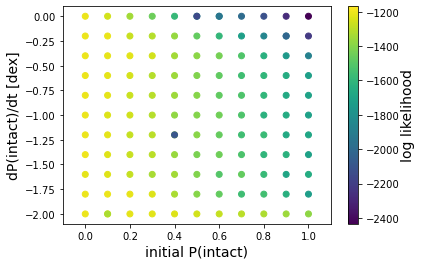

In [227]:
#mean_df = mean_df.loc[(mean_df.m <= 0) & (mean_df.m >= -2.)]
#mean_df = mean_df.loc[(mean_df.b <= 1) & (mean_df.b >= 0.)]
#clean_df = mean_df.loc[(np.round(mean_df.m, 1).isin(ms)) & (np.round(mean_df.b, 1).isin(bs))]
clean_df = mean_df.loc[(mean_df.m <= 0.) & (mean_df.m >= -2.) & (mean_df.b >= 0.) & (mean_df.b <= 1.) & (mean_df.logL <= 0.)].dropna()
print(clean_df)
marg = clean_df.groupby(['m','b'], as_index=False).mean('logL')

plt.scatter(np.round(marg.b, 1), np.round(marg.m, 1), c=marg.logL)
plt.xlabel('initial P(intact)', fontsize=14)
plt.ylabel('dP(intact)/dt [dex]', fontsize=14)
#plt.yticks(point_two.ms[::2])
#plt.locator_params(axis='y', nbins=10)
plt.gca().invert_yaxis()
#plt.yscale('symlog')
#plt.yscale('log')
#plt.ylim([1, -2.1])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='log likelihood',size=14, labelpad=2)
plt.savefig('marginalized_logLs_incremental.png', bbox_inches='tight')
plt.xlim(-0.1, 1.1)
plt.ylim(-2.1, 0.1)
plt.show()

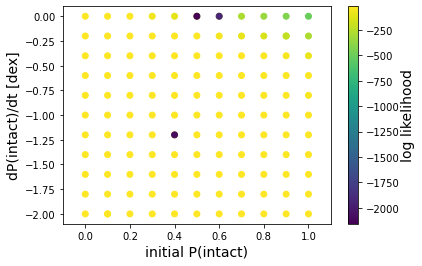

In [271]:
marg_max = clean_df.groupby(['m','b'], as_index=False).max('logL')

plt.scatter(np.round(marg_max.b, 1), np.round(marg_max.m, 1), c=marg_max.logL)
plt.xlabel('initial P(intact)', fontsize=14)
plt.ylabel('dP(intact)/dt [dex]', fontsize=14)
#plt.yticks(point_two.ms[::2])
#plt.locator_params(axis='y', nbins=10)
plt.gca().invert_yaxis()
#plt.yscale('symlog')
#plt.yscale('log')
#plt.ylim([1, -2.1])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='log likelihood',size=14, labelpad=2)
plt.savefig('marginalized_max_logLs_incremental.png', bbox_inches='tight')
plt.xlim(-0.1, 1.1)
plt.ylim(-2.1, 0.1)
plt.show()

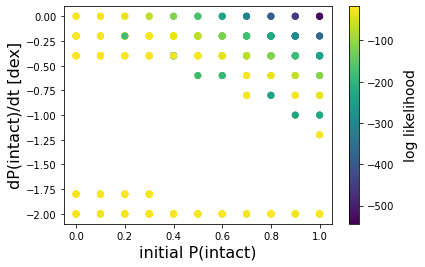

In [338]:
clean_cf = clean_df.loc[(round(clean_df.c, 
                               1)<1e9+1) & (round(clean_df.c, 
                                                  1)>1e9-1) & (round(clean_df.f,
                                                                     1)==0.2)]
plt.scatter(clean_cf.b, clean_cf.m, c=clean_cf.logL)
plt.xlabel('initial P(intact)', fontsize=16)
plt.ylabel('dP(intact)/dt [dex]', fontsize=16)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='log likelihood',size=14, labelpad=10)
plt.savefig('example_logL.eps', format='eps', bbox_inches='tight')
plt.show()

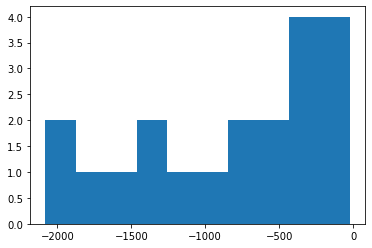

In [359]:
nonzero_df = df.loc[df.fs > 0]
plt.hist(nonzero_df.loc[(nonzero_df.ms==-2.)&(nonzero_df.bs==0.0)].correct_mean_logLs.dropna(), 
         bins=10)
plt.show()

In [234]:
#df_ten_billion = clean_df.loc[(clean_df.c >= 1e10)].reset_index()
#point_two = df_ten_billion.loc[df_ten_billion.f == 0.2]
df_ten_billion = clean_df.loc[(clean_df.c >= 1e10)]
point_two = df_ten_billion.loc[clean_df.f == 0.2]
bs = point_two.b.reset_index()
#logLs = point_two.logL
#print(logLs)
print(bs)
print(point_two.m)



     index    b
0      112  0.0
1      123  0.0
2      134  0.0
3      145  0.0
4      156  0.0
..     ...  ...
382  56610  0.9
383  56621  0.9
384  56632  0.9
385  56643  0.9
386  56654  0.9

[387 rows x 2 columns]
112     -2.0
123     -2.0
134     -2.0
145     -2.0
156     -2.0
        ... 
56610   -0.2
56621   -0.2
56632   -0.2
56643   -0.2
56654   -0.2
Name: m, Length: 387, dtype: float64


In [235]:
ndim = 3
nparams = 3
cube = [0, 0, 0]

def prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c):
	"""
	Each model run will use an evenly spaced (m,b, cutoff) tuple on a discrete 11x11x11 3D grid
	We're doing log(time), so slope is sampled linearly (everything gets logged together later)
	If a cutoff results in a zero probability, don't bother 

	gi_m: grid index on m axis
	gi_b: grid index on b axis
	gi_c: grid index for cutoff time axis
	"""
	#cube[0] = -1e-9*np.logspace(8,10,11)[gi_m] # convert from year to Gyr
	cube[0] = np.linspace(-2,0,11)[gi_m] 
	cube[1] = np.linspace(0,1,11)[gi_b]
	#cube[2] = np.logspace(1e8,1e10,11)
	cube[2] = np.logspace(8,10,11)[gi_c] # in Ballard et al in prep, they use log(yrs) instead of drawing yrs from logspace
	return cube

(array([110.,   0.,   0.,   0.,  10., 112., 218., 220., 540.]),
 array([-5434.56855458, -4832.55951391, -4230.55047325, -3628.54143259,
        -3026.53239192, -2424.52335126, -1822.51431059, -1220.50526993,
         -618.49622927,   -16.4871886 ]),
 <BarContainer object of 9 artists>)

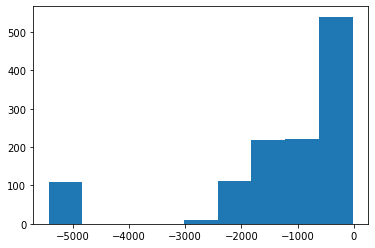

In [242]:
clean_df.loc[(np.round(clean_df.m, 1) == -2.0) & (np.round(clean_df.b, 1) == 0.3)].logL
plt.hist(clean_df.loc[(np.round(clean_df.m, 1) == -2.0) & (np.round(clean_df.b, 1) == 0.3)].logL.dropna(), bins=bins)

-5000 -16.487188604241055


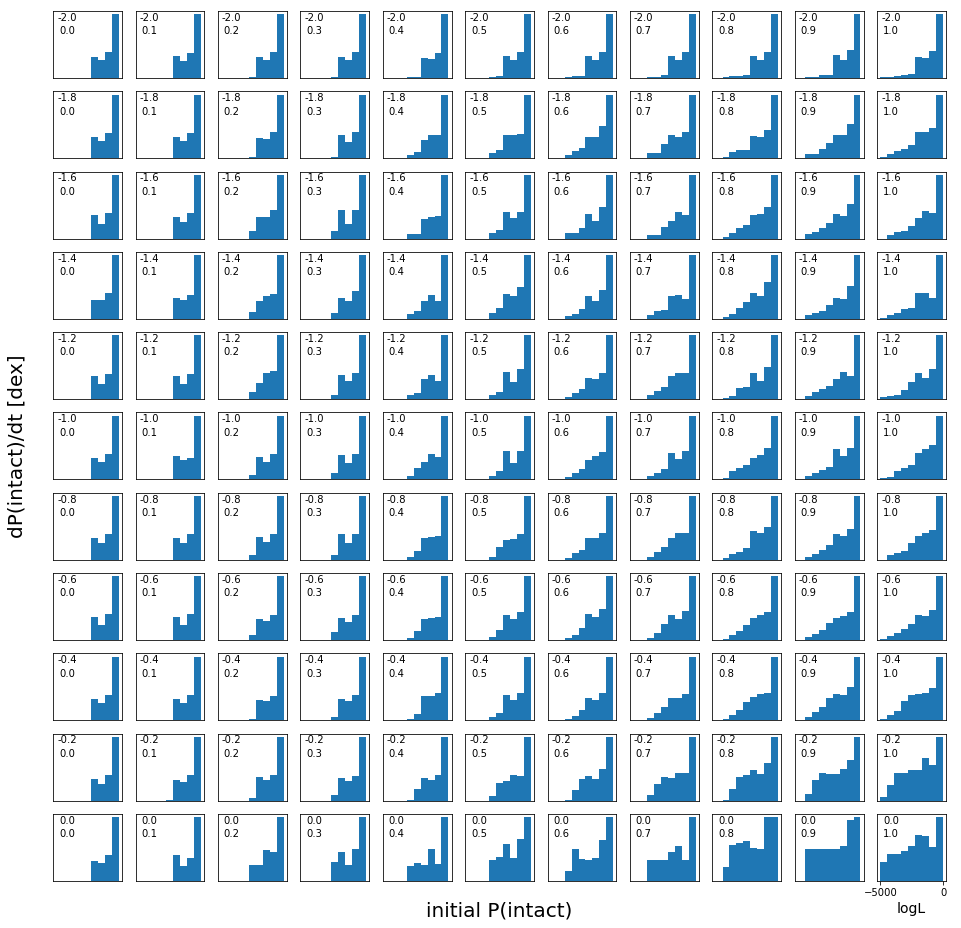

In [245]:
lower = min(clean_df.logL)
lower = -5000
upper = max(clean_df.logL)
print(lower, upper)
bins = np.linspace(lower, upper, 10)

fig = plt.figure(figsize=(16,16))
m_index = 0
b_index = 0
gi_c = 0
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
        m = np.round(cube[0], 1)
        b = np.round(cube[1], 1)
        ax.text(0.2, 0.9, round(m, 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, round(b,1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.hist(clean_df.loc[(np.round(clean_df.m, 1)==m)&(np.round(clean_df.b, 1)==b)].logL.dropna(), 
         bins=bins)
        
        m_index += 1
        b_index += 1
        #ax.set_xlim(lower, upper)
        
        if m_index < 121:
            ax.get_xaxis().set_visible(False)
        else:
            ax.get_xaxis().set_visible(True)  
            ax.set_xlabel('logL', fontsize=14)

        ax.get_yaxis().set_visible(False)

        #index += 1
# add axis labels in the middle of the subplot
fig.add_subplot(111, frameon=False)
# this hack introduces tick marks, so hide them
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.xlabel('initial P(intact)', fontsize=20)
plt.ylabel('dP(intact)/dt [dex]', fontsize=20)
plt.savefig('posteriors_incremental.png')
plt.show()

-5434.568554576411 -16.487188604241055


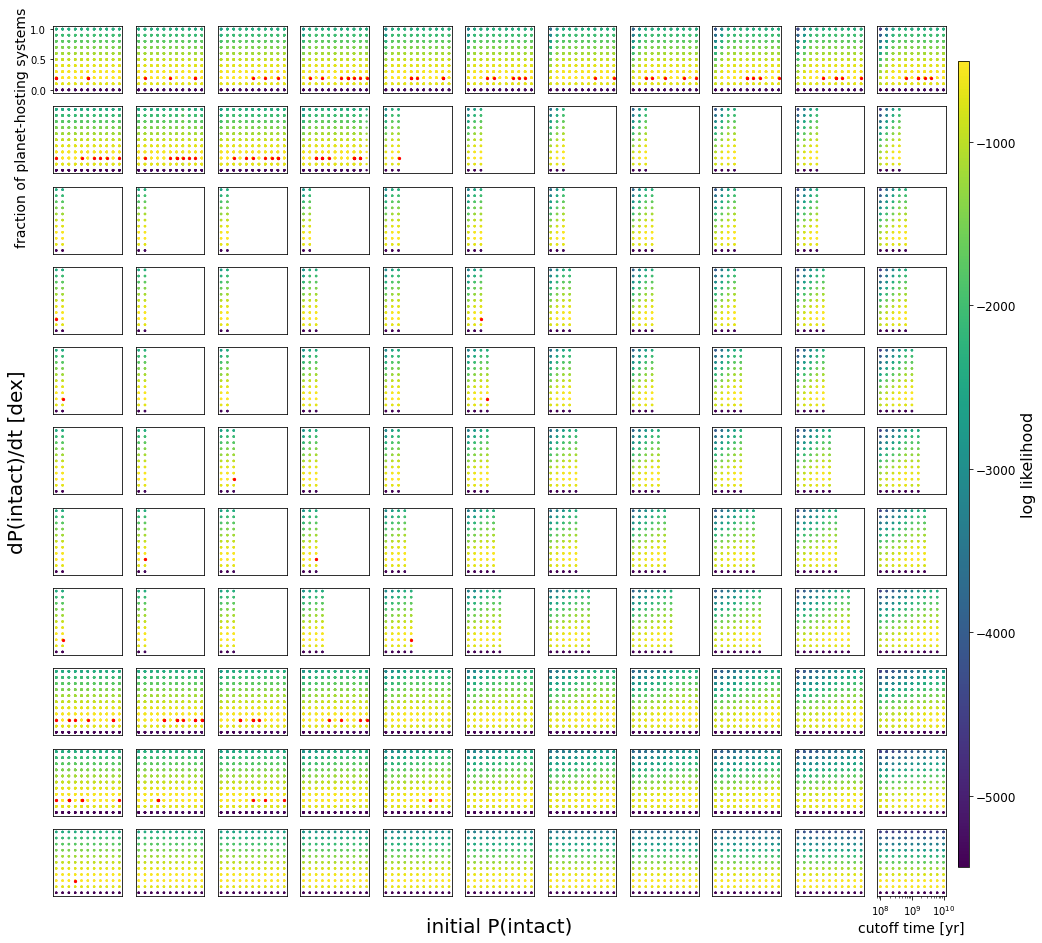

In [251]:
lower = min(clean_df.logL)
upper = max(clean_df.logL)
print(lower, upper)
bins = np.linspace(lower, upper, 10)

fig = plt.figure(figsize=(16,16))
m_index = 0
b_index = 0
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        #b = clean_df.b.reset_index().b[b_index]
        #m = clean_df.m.reset_index().m[m_index]
        #c = df.cs[bs.index].reset_index().cs[m_index]
        #f = df.fs[bs.index].reset_index().fs[m_index]
        cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
        m = np.round(cube[0], 1)
        b = np.round(cube[1], 1)
                
        temp_df = clean_df.loc[(np.round(clean_df.m, 1)==m)&(np.round(clean_df.b, 1)==b)]
        im = ax.scatter(temp_df.c, temp_df.f, s=2, c=temp_df.logL)
        
        best_df = clean_df.loc[(np.round(clean_df.m, 1)==m)&(np.round(clean_df.b, 1)==b)&(clean_df.logL>-20)]
        im_best = ax.scatter(best_df.c, best_df.f, s=5, c='r')

        m_index += 1
        b_index += 1
        #ax.set_xlim(lower, upper)
        
        if m_index==121:
            ax.set_xlabel('cutoff time [yr]', fontsize=14)
            ax.get_yaxis().set_visible(False)
        elif m_index==1:
            ax.set_ylabel('fraction of planet-hosting systems', fontsize=14)
            ax.yaxis.set_label_coords(-0.35, -0.5)
            ax.get_xaxis().set_visible(False)
        else:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
        
        ax.set_xlim(1e8-2e7, 1e10+2e9)
        ax.set_xscale('log')

        #index += 1
# add axis labels in the middle of the subplot
fig.add_subplot(111, frameon=False)
# this hack introduces tick marks, so hide them
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('initial P(intact)', fontsize=20)
plt.ylabel('dP(intact)/dt [dex]', fontsize=20)

cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = fig.colorbar(im, cbar_ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='log likelihood', size=16)
#fig.tight_layout() # this isn't compatible with the mini-y-axis label positioning
plt.savefig('highlight_best_models_incremental_20.eps', format='eps')
plt.show()

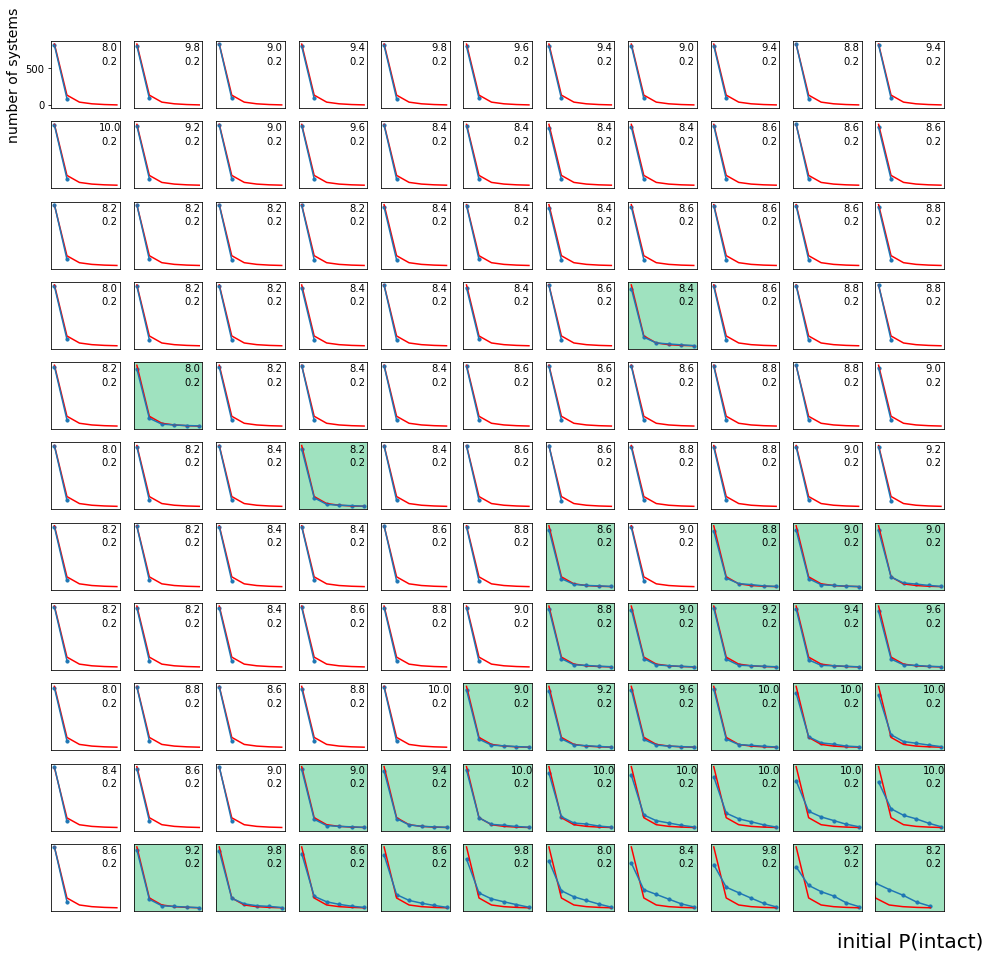

In [318]:
plt.figure(figsize=(16,16))
index = 0
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        
        cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
        m = np.round(cube[0], 1)
        b = np.round(cube[1], 1)
         
        temp_df = clean_df.loc[(np.round(clean_df.m, 1)==m)&(np.round(clean_df.b, 1)==b)]
        #temp_df = temp_df.loc[(np.round(clean_df.c, 1)==c)&(np.round(clean_df.f, 1)==f)]
        
        # for each (m,b), what's the best model?
        best_logL = max(temp_df.logL)
        best_df = temp_df.loc[temp_df.logL >= best_logL]
        best_model = best_df.transit_multiplicity
        
        """
        # collect ith elements across transit multiplicities per model
        lam_elt_max = []
        lam_elt_min = []
        lam_elt_avg = []
        for temp_list in zip_longest(*lam_elt):
            #print(temp_list)
            elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
            lam_elt_max.append(max(elt))
            lam_elt_min.append(min(elt))
            lam_elt_avg.append(np.mean(elt))
        """
        
        # plotting
        ax.plot(np.arange(len(k)), k, color='r')
        ax.plot(np.arange(len(list(best_model)[0][0])), list(best_model)[0][0])
        #ax.scatter(np.arange(len(k)), k, marker=(5, 1), color='r', s=10)
        ax.scatter(np.arange(len(list(best_model)[0][0])), list(best_model)[0][0], s=10)
        
        # labels
        if index==120:
            ax.set_xlabel('transit multiplicity', fontsize=14)
            ax.get_yaxis().set_visible(False)
        elif index==0:
            ax.set_ylabel('number of systems', fontsize=14)
            #ax.yaxis.set_label_coords(-0.35, -0.5)
            ax.get_xaxis().set_visible(False)
        else:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False) 
            
        c = np.round(np.log10(np.round(list(best_df.c)[0], 1)), 1)
        f = np.round(list(best_df.f)[0], 1)
        ax.text(0.85, 0.9, c, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.85, 0.7, f, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        
        # shading
        if len(list(best_model)[0][0])>=3:
            ax.set_facecolor('#9fe2bf') ##eafff5
        
        index += 1

# add axis labels in the middle of the subplot
fig.add_subplot(111, frameon=False)
# this hack introduces tick marks, so hide them
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('initial P(intact)', fontsize=20)
plt.ylabel('dP(intact)/dt [dex]', fontsize=20)
plt.xlim(1, 6)
plt.savefig('best_models.eps', format='eps')
plt.show()

In [ ]:
round(list(best_df.f)[0], 1)

0.2

### Intact fractions

Intact fraction is out of all stars. So to get intact fraction of **planet-hosting** stars, I need to divide by f. 

In [340]:
np.std(clean_df.logL)

1512.7940698699124

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


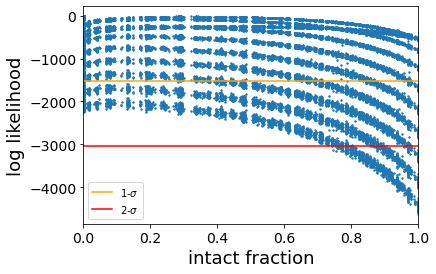

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


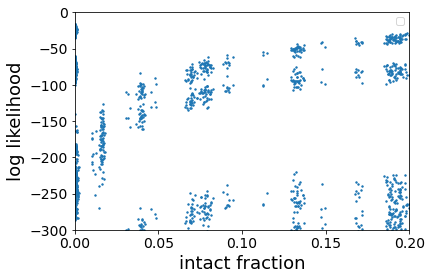

In [366]:
plt.scatter(clean_df.intact_frac/clean_df.f, clean_df.logL, s=2)
plt.plot([0, 1], np.ones(2)*(max(clean_df.logL)-np.std(clean_df.logL)), c='orange', label=r'1-$\sigma$')
plt.plot([0, 1], np.ones(2)*(max(clean_df.logL)-2*np.std(clean_df.logL)), c='r', label=r'2-$\sigma$')
plt.xlabel('intact fraction', fontsize=18)
plt.ylabel('log likelihood', fontsize=18)
plt.xlim(0, 1)
plt.tick_params(axis='both', labelsize=14)
plt.legend()
plt.savefig('intact_fracs.eps', format='eps', bbox_inches='tight')
plt.show()

plt.scatter(clean_df.intact_frac/clean_df.f, clean_df.logL, s=2)
plt.xlabel('intact fraction', fontsize=18)
plt.ylabel('log likelihood', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.xlim(0, 0.2)
plt.ylim(-300, 0)
plt.legend()
plt.savefig('intact_fracs_zoom.eps', format='eps', bbox_inches='tight')
plt.show()

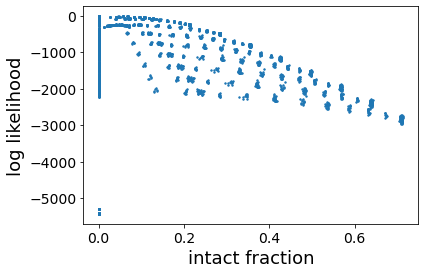

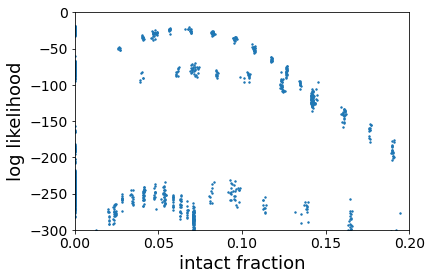

In [327]:
plt.scatter(clean_df.loc[np.round(clean_df.b, 1)==0.4].intact_frac, 
            clean_df.loc[np.round(clean_df.b, 1)==0.4].logL, s=2)
plt.xlabel('intact fraction', fontsize=18)
plt.ylabel('log likelihood', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.savefig('intact_fracs.eps', format='eps')
plt.show()

plt.scatter(clean_df.loc[np.round(clean_df.b, 1)==0.4].intact_frac, 
            clean_df.loc[np.round(clean_df.b, 1)==0.4].logL, s=2)
plt.xlabel('intact fraction', fontsize=18)
plt.ylabel('log likelihood', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.xlim(0, 0.2)
plt.ylim(-300, 0)
plt.savefig('intact_fracs_zoom.eps', format='eps')
plt.show()

Which model corresponds with the highest-reaching curve of intact fractions?

                                                filename    f    m    b  \
51352  /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -0.2  0.4   

                  c       logL  intact_frac  disrupted_frac  \
51352  2.511886e+09 -19.672917     0.068588        0.131412   

                                    transit_multiplicity  
51352  [[774.4000000000001, 121.0, 35.6, 15.8, 8.2000...  
[774.4000000000001, 121.0, 35.6, 15.8, 8.200000000000001, 1.6]


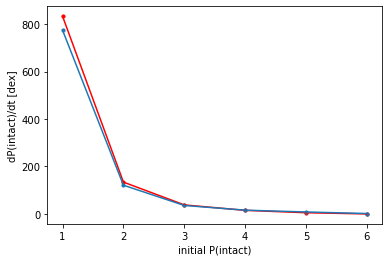

In [370]:
best = clean_df.loc[(clean_df.logL > -20) & (clean_df.intact_frac > 0.05)]
best_intact_multiplicity = best.transit_multiplicity
print(best)
print(list(best_intact_multiplicity)[0][0])
# plotting
plt.plot(np.arange(len(k))+1, k, color='r')
plt.scatter(np.arange(len(k))+1, k, color='r', s=10)
plt.plot(np.arange(len(list(best_intact_multiplicity)[0][0]))+1, list(best_intact_multiplicity)[0][0])
#ax.scatter(np.arange(len(k)), k, marker=(5, 1), color='r', s=10)
plt.scatter(np.arange(len(list(best_intact_multiplicity)[0][0]))+1, list(best_intact_multiplicity)[0][0], s=10)
plt.xlabel('initial P(intact)')#, fontsize=20)
plt.ylabel('dP(intact)/dt [dex]')#, fontsize=20)
#plt.xlim(1, 6)
#plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.savefig('best_model_intact.eps', format='eps', bbox_inches='tight')
plt.show()

Random models for presentation; keeping variable and file names the same as above, so rerun the above block to reset after this.

In [362]:
best = clean_df.loc[(clean_df.logL > -20)]
print(best)

                                                filename    f    m    b  \
57     /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  0.0   
68     /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  0.0   
728    /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  0.0   
739    /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  0.0   
1817   /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  1.0   
...                                                  ...  ...  ...  ...   
47227  /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -0.2  0.1   
48151  /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -0.2  0.2   
48690  /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -0.2  0.2   
48910  /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -0.2  0.2   
51352  /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -0.2  0.4   

                  c       logL  intact_frac  disrupted_frac  \
57     1.000000e+08 -18.396507     0

In [368]:
np.arange(len(k))+1

array([1, 2, 3, 4, 5, 6])

                                               filename    f    m    b  \
1817  /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  1.0   
2059  /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  1.0   
2081  /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  1.0   
2136  /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  1.0   
2268  /blue/sarahballard/c.lam/sculpting2/simulation...  0.2 -2.0  1.0   

                 c       logL  intact_frac  disrupted_frac  \
1817  6.309573e+08 -16.682169          0.0             0.2   
2059  1.584893e+09 -19.317146          0.0             0.2   
2081  1.584893e+09 -17.074444          0.0             0.2   
2136  2.511886e+09 -16.487189          0.0             0.2   
2268  3.981072e+09 -18.753351          0.0             0.2   

                                   transit_multiplicity  
1817  [[808.6, 91.4], [808.6, 91.4], [808.6, 91.4], ...  
2059  [[813.2, 86.0], [813.2, 86.0], [813.2, 86.0], ...  
2081  [[

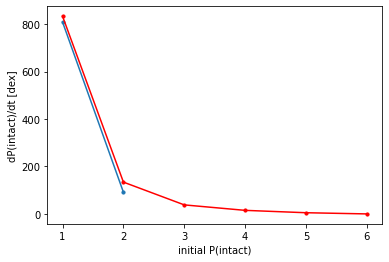

In [369]:
best = clean_df.loc[(clean_df.logL > -20)&(np.round(clean_df.m,1)==-2.)&(np.round(clean_df.b,1)==1.0)]
print(best)
best_intact_multiplicity = best.transit_multiplicity
# plotting
plt.plot(np.arange(len(k))+1, k, color='r')
plt.scatter(np.arange(len(k))+1, k, color='r', s=10)
plt.plot(np.arange(len(list(best_intact_multiplicity)[0][0]))+1, list(best_intact_multiplicity)[0][0])
#ax.scatter(np.arange(len(k)), k, marker=(5, 1), color='r', s=10)
plt.scatter(np.arange(len(list(best_intact_multiplicity)[0][0]))+1, list(best_intact_multiplicity)[0][0], s=10)
plt.xlabel('initial P(intact)')#, fontsize=20)
plt.ylabel('dP(intact)/dt [dex]')#, fontsize=20)
#plt.xlim(1, 6)
#plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.savefig('best_model_intact.eps', format='eps', bbox_inches='tight')
plt.show()

### Cutoff time and fraction of planet-hosting stars

In [91]:
np.std(df.correct_mean_logLs)

1530.3953098156203

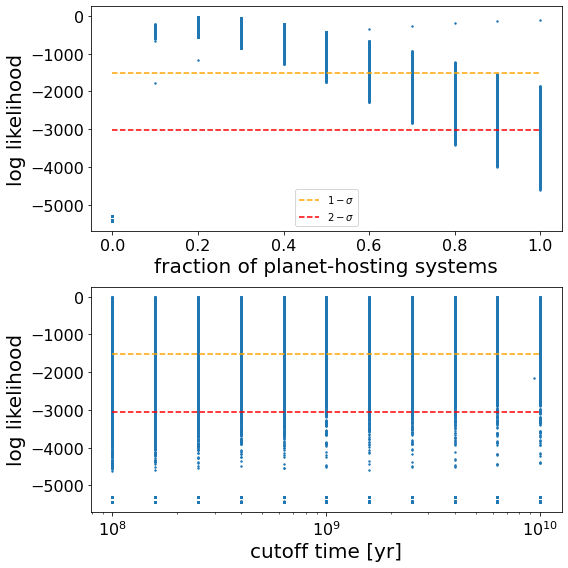

In [231]:
max_logL_overall = max(clean_df.logL)
fig, axes = plt.subplots(figsize=(8,8))
ax1 = plt.subplot2grid((2,1), (0,0))
ax1.scatter(clean_df.f, clean_df.logL, s=2)
ax1.plot([0, 1], [-np.std(clean_df.logL), -np.std(clean_df.logL)], 
         linestyle='--', c='orange', label=r'$1-\sigma$')
ax1.plot([0, 1], [-2*np.std(clean_df.logL), -2*np.std(clean_df.logL)], 
         linestyle='--', c='r', label=r'$2-\sigma$')
#ax1.set_ylim(-5000, 100)
ax1.set_xlabel('fraction of planet-hosting systems', fontsize=20)
ax1.set_ylabel('log likelihood', fontsize=20)
ax1.tick_params(axis='both', labelsize=16)
ax1.legend()

ax2 = plt.subplot2grid((2,1), (1,0))
ax2.scatter(clean_df.c, clean_df.logL, s=2)
ax2.plot([1e8, 1e10], [max_logL_overall-np.std(clean_df.logL), 
                       max_logL_overall-np.std(clean_df.logL)], 
         linestyle='--', c='orange', label=r'$1-\sigma$')
ax2.plot([1e8, 1e10], [max_logL_overall-2*np.std(clean_df.logL), 
                       max_logL_overall-2*np.std(clean_df.logL)], 
         linestyle='--', c='r', label=r'$2-\sigma$')
#plt.ylim(-4000, 100)
ax2.set_xscale('log')
ax2.set_xlabel('cutoff time [yr]', fontsize=20)
ax2.set_ylabel('log likelihood', fontsize=20)
ax2.tick_params(axis='both', labelsize=16)

fig.tight_layout()
plt.savefig('frac_and_cutoff_incremental.png', bbox_inches='tight')
plt.show()

### Young vs old ecc-inc distributions

In [27]:
df = pd.read_csv('transits5_9_5_2.csv')
print(df.head())
print(np.min(df.iso_age))
print(len(df.loc[df.intact_flag=='disrupted']))
print(len(df.loc[df.intact_flag=='intact']))

   Unnamed: 0   kepid           tm_designation  teff  teff_err1  teff_err2  \
0           0  757280  2MASS J19242289+3633538  6543      162.0     -194.0   
1           1  892195  2MASS J19240520+3638374  5522      194.0     -155.0   
2           1  892195  2MASS J19240520+3638374  5522      194.0     -155.0   
3           2  892667  2MASS J19243045+3637186  6609      159.0     -227.0   
4           2  892667  2MASS J19243045+3637186  6609      159.0     -227.0   

    logg  logg_err1  logg_err2  feh_x  ...  intact_flag  num_planets  \
0  4.082      0.258     -0.172  -0.24  ...    disrupted            1   
1  3.984      0.510     -0.170  -0.06  ...    disrupted            2   
2  3.984      0.510     -0.170  -0.06  ...    disrupted            2   
3  4.105      0.246     -0.164  -0.26  ...    disrupted            2   
4  4.105      0.246     -0.164  -0.26  ...    disrupted            2   

        ecc      incl     omega  planet_radius  mutual_incl  transit_status  \
0  0.438226  1.4272

/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (139) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (139) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.7324166657669405
0.2375142104512306


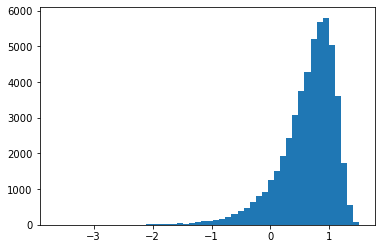

['Unnamed: 0', 'kepid', 'tm_designation', 'teff', 'teff_err1', 'teff_err2', 'logg', 'logg_err1', 'logg_err2', 'feh_x', 'feh_err1', 'feh_err2', 'mass', 'mass_err1', 'mass_err2', 'st_radius', 'radius_err1', 'radius_err2', 'dens', 'dens_err1', 'dens_err2', 'prov_sec', 'kepmag', 'dist', 'dist_err1', 'dist_err2', 'nconfp', 'nkoi', 'ntce', 'datalink_dvr', 'st_delivname', 'st_vet_date_str', 'degree_ra', 'degree_dec', 'st_quarters', 'teff_prov', 'logg_prov', 'feh_prov', 'jmag', 'jmag_err', 'hmag', 'hmag_err', 'kmag_x', 'kmag_err_x', 'dutycycle', 'dataspan', 'mesthres01p5', 'mesthres02p0', 'mesthres02p5', 'mesthres03p0', 'mesthres03p5', 'mesthres04p5', 'mesthres05p0', 'mesthres06p0', 'mesthres07p5', 'mesthres09p0', 'mesthres10p5', 'mesthres12p0', 'mesthres12p5', 'mesthres15p0', 'rrmscdpp01p5', 'rrmscdpp02p0', 'rrmscdpp02p5', 'rrmscdpp03p0', 'rrmscdpp03p5', 'rrmscdpp04p5', 'rrmscdpp05p0', 'rrmscdpp06p0', 'rrmscdpp07p5', 'rrmscdpp09p0', 'rrmscdpp10p5', 'rrmscdpp12p0', 'rrmscdpp12p5', 'rrmscdpp15p

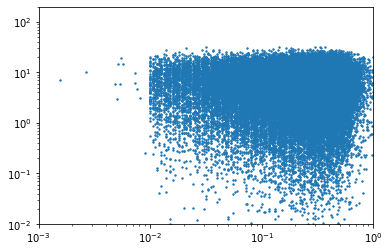

/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'yscale', 'xscale'
  cset = contour_func(
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_4683/1114948090.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-2, 2)


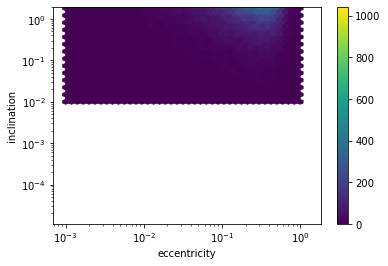

In [23]:
df = pd.read_csv('transits5_9_5_2.csv')
print(np.nanmedian(np.log10(df.mutual_incl*180/np.pi)))
print(np.nanmedian(df.ecc))

plt.hist(np.log10(df.mutual_incl*180/np.pi), bins=50)
plt.show()

#print(df.head())
print(list(df.columns))
plt.scatter(df.ecc, df.mutual_incl*180/np.pi, s=2)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-3,1e0)
plt.ylim(1e-2,2e2)
plt.show()

plt.hexbin(df.ecc, np.abs(df.mutual_incl)*180/np.pi, gridsize=40, yscale='log', xscale='log', extent=(-3, 0, -2, 2))
fig2 = sns.kdeplot(np.array(df.ecc), np.array(np.abs(df.mutual_incl)*180/np.pi), yscale='log', xscale='log', legend = True, 
                   levels=[0.68, 0.95], colors=['black','red'])
plt.ylim(-2, 2)
#plt.xlim(0, 0.5)
plt.xlabel('eccentricity')
plt.ylabel('inclination')
plt.colorbar()
plt.show()

/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (0,4,5,6,110,114,115,139,141) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.7327892175530898


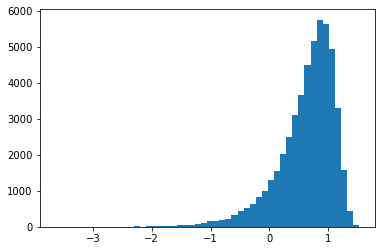

['Unnamed: 0', 'kepid', 'tm_designation', 'teff', 'teff_err1', 'teff_err2', 'logg', 'logg_err1', 'logg_err2', 'feh_x', 'feh_err1', 'feh_err2', 'mass', 'mass_err1', 'mass_err2', 'st_radius', 'radius_err1', 'radius_err2', 'dens', 'dens_err1', 'dens_err2', 'prov_sec', 'kepmag', 'dist', 'dist_err1', 'dist_err2', 'nconfp', 'nkoi', 'ntce', 'datalink_dvr', 'st_delivname', 'st_vet_date_str', 'degree_ra', 'degree_dec', 'st_quarters', 'teff_prov', 'logg_prov', 'feh_prov', 'jmag', 'jmag_err', 'hmag', 'hmag_err', 'kmag_x', 'kmag_err_x', 'dutycycle', 'dataspan', 'mesthres01p5', 'mesthres02p0', 'mesthres02p5', 'mesthres03p0', 'mesthres03p5', 'mesthres04p5', 'mesthres05p0', 'mesthres06p0', 'mesthres07p5', 'mesthres09p0', 'mesthres10p5', 'mesthres12p0', 'mesthres12p5', 'mesthres15p0', 'rrmscdpp01p5', 'rrmscdpp02p0', 'rrmscdpp02p5', 'rrmscdpp03p0', 'rrmscdpp03p5', 'rrmscdpp04p5', 'rrmscdpp05p0', 'rrmscdpp06p0', 'rrmscdpp07p5', 'rrmscdpp09p0', 'rrmscdpp10p5', 'rrmscdpp12p0', 'rrmscdpp12p5', 'rrmscdpp15p

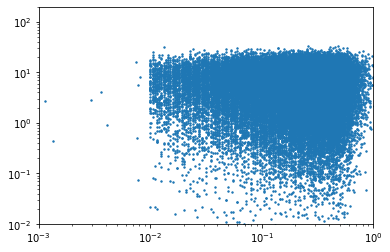

/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'yscale', 'xscale'
  cset = contour_func(
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_4683/1824060561.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-2, 2)


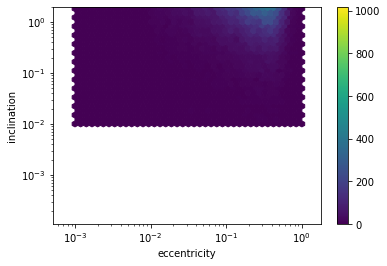

In [20]:
df = pd.read_csv('transits0_0_0_0.csv')
#print(df.head())

print(np.nanmedian(np.log10(df.mutual_incl*180/np.pi)))

plt.hist(np.log10(df.mutual_incl*180/np.pi), bins=50)
plt.show()

print(list(df.columns))
plt.scatter(df.ecc, df.mutual_incl*180/np.pi, s=2)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-3,1e0)
plt.ylim(1e-2,2e2)
plt.show()

plt.hexbin(df.ecc, np.abs(df.mutual_incl)*180/np.pi, gridsize=40, yscale='log', xscale='log', extent=(-3, 0, -2, 2))
fig2 = sns.kdeplot(np.array(df.ecc), np.array(np.abs(df.mutual_incl)*180/np.pi), yscale='log', xscale='log', legend = True, 
                   levels=[0.68, 0.95], colors=['black','red'])
plt.ylim(-2, 2)
#plt.xlim(0, 0.5)
plt.xlabel('eccentricity')
plt.ylabel('inclination')
plt.colorbar()
plt.show()

In [21]:
print(np.nanmedian(df.ecc))

0.2370969629634485


/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (139) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


   Unnamed: 0   kepid           tm_designation  teff  teff_err1  teff_err2  \
0           0  757280  2MASS J19242289+3633538  6543      162.0     -194.0   
1           0  757280  2MASS J19242289+3633538  6543      162.0     -194.0   
2           1  892195  2MASS J19240520+3638374  5522      194.0     -155.0   
3           1  892195  2MASS J19240520+3638374  5522      194.0     -155.0   
4           2  892667  2MASS J19243045+3637186  6609      159.0     -227.0   

    logg  logg_err1  logg_err2  feh_x  ...      incl     omega  planet_radius  \
0  4.082      0.258     -0.172  -0.24  ...  1.057226  0.029696            2.0   
1  4.082      0.258     -0.172  -0.24  ...  1.258502  0.518401            2.0   
2  3.984      0.510     -0.170  -0.06  ... -0.961080  1.968308            2.0   
3  3.984      0.510     -0.170  -0.06  ... -0.714896  4.322335            2.0   
4  4.105      0.246     -0.164  -0.26  ... -1.149727  6.071557            2.0   

   planet_mass  mutual_incl     lambda_ks  s

/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


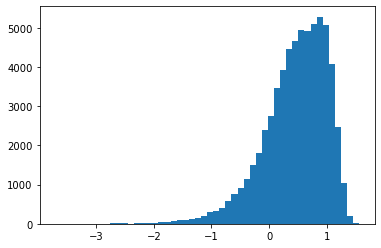

['Unnamed: 0', 'kepid', 'tm_designation', 'teff', 'teff_err1', 'teff_err2', 'logg', 'logg_err1', 'logg_err2', 'feh_x', 'feh_err1', 'feh_err2', 'mass', 'mass_err1', 'mass_err2', 'st_radius', 'radius_err1', 'radius_err2', 'dens', 'dens_err1', 'dens_err2', 'prov_sec', 'kepmag', 'dist', 'dist_err1', 'dist_err2', 'nconfp', 'nkoi', 'ntce', 'datalink_dvr', 'st_delivname', 'st_vet_date_str', 'degree_ra', 'degree_dec', 'st_quarters', 'teff_prov', 'logg_prov', 'feh_prov', 'jmag', 'jmag_err', 'hmag', 'hmag_err', 'kmag_x', 'kmag_err_x', 'dutycycle', 'dataspan', 'mesthres01p5', 'mesthres02p0', 'mesthres02p5', 'mesthres03p0', 'mesthres03p5', 'mesthres04p5', 'mesthres05p0', 'mesthres06p0', 'mesthres07p5', 'mesthres09p0', 'mesthres10p5', 'mesthres12p0', 'mesthres12p5', 'mesthres15p0', 'rrmscdpp01p5', 'rrmscdpp02p0', 'rrmscdpp02p5', 'rrmscdpp03p0', 'rrmscdpp03p5', 'rrmscdpp04p5', 'rrmscdpp05p0', 'rrmscdpp06p0', 'rrmscdpp07p5', 'rrmscdpp09p0', 'rrmscdpp10p5', 'rrmscdpp12p0', 'rrmscdpp12p5', 'rrmscdpp15p

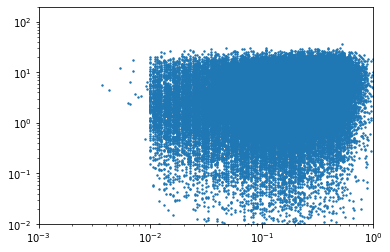

/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'yscale', 'xscale'
  cset = contour_func(
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_16355/1720113572.py:24: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-2, 2)


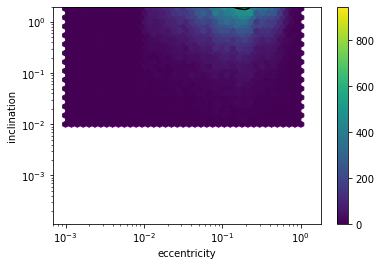

In [210]:
df = pd.read_csv('transits02_04_04_25.csv')
print(df.head())
print(np.min(df.iso_age))
print(len(df.loc[df.intact_flag=='disrupted']))
print(len(df.loc[df.intact_flag=='intact']))

print(np.nanmedian(np.log10(df.mutual_incl*180/np.pi)))
print(np.nanmedian(df.ecc))

plt.hist(np.log10(df.mutual_incl*180/np.pi), bins=50)
plt.show()

print(list(df.columns))
plt.scatter(df.ecc, df.mutual_incl*180/np.pi, s=2)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-3,1e0)
plt.ylim(1e-2,2e2)
plt.show()

plt.hexbin(df.ecc, np.abs(df.mutual_incl)*180/np.pi, gridsize=40, yscale='log', xscale='log', extent=(-3, 0, -2, 2))
fig2 = sns.kdeplot(np.array(df.ecc), np.array(np.abs(df.mutual_incl)*180/np.pi), yscale='log', xscale='log', legend = True, 
                   levels=[0.68, 0.95], colors=['black','red'])
plt.ylim(-2, 2)
#plt.xlim(0, 0.5)
plt.xlabel('eccentricity')
plt.ylabel('inclination')
plt.colorbar()
plt.show()

### Plot model vs data transit multiplicities

In [209]:
young = df.loc[df.iso_age <= 1]
old = df.loc[df.iso_age > 1]
print(len(young), len(old))
print(k[1:])

frac = 0.25
transiters_berger_kepler = df.loc[df['transit_status']==1]
transit_multiplicity = frac*transiters_berger_kepler.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
normalize = k[1]/transit_multiplicity[0]
print(transit_multiplicity)

transiters_berger_kepler_young = young.loc[young['transit_status']==1]
transit_multiplicity_young = frac*transiters_berger_kepler_young.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
normalize_young = k[1]/transit_multiplicity_young[0]
print(transit_multiplicity_young)

transiters_berger_kepler_old = old.loc[old['transit_status']==1]
transit_multiplicity_old = frac*transiters_berger_kepler_old.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
normalize_old = k[1]/transit_multiplicity_old[0]
print(transit_multiplicity_old)

plt.scatter(np.arange(6)[1:], k[1:], marker=(5, 1), color='r', s=10)
plt.scatter(np.arange(7)[1:], normalize*transit_multiplicity, s=2)
plt.xlabel('multiplicity')
plt.ylabel('count normalized against Kepler data')
plt.title('all planets')
plt.show()

fig, axes = plt.subplots(figsize=(8,8))
ax1 = plt.subplot2grid((2,1), (0,0))
#plt.figure()
temp_k = [*k,0]
print(temp_k)
ax1.scatter(np.arange(7)[1:], k, marker=(5, 1), color='r', s=10, label=r'$Kepler$')
ax1.scatter(np.arange(7)[1:], normalize_young*transit_multiplicity_young, s=2, label='model')
#ax1.set_xlabel('multiplicity', fontsize=14)
ax1.set_ylabel('count normalized against Kepler data', fontsize=14)
ax1.set_title('young planets', fontsize=18)
ax1.legend(prop={'size': 6})

ax2 = plt.subplot2grid((2,1), (1,0))
ax2.scatter(np.arange(7)[1:], k, marker=(5, 1), color='r', s=10, label=r'$Kepler$')
ax2.scatter(np.arange(7)[1:], normalize_old*transit_multiplicity_old, s=2, label='model')
ax2.set_xlabel('multiplicity', fontsize=14)
ax2.set_ylabel('count normalized against Kepler data', fontsize=14)
ax2.set_title('old planets', fontsize=18)
ax2.legend(prop={'size': 6})

fig.tight_layout()
plt.savefig('young_v_old_best_model.eps', format='eps')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'iso_age'

#### Best model yet

transit multiplicity:  [931.25, 129.0, 29.0, 24.75, 11.75, 2.25]

k:  [833, 134, 38, 15, 5, 0]

logL:  -28.11717015937918

old logL:  -166.8393399861186

total:  126860

transiters:  5790


#### Best model (now excluding the zero bin)

In [279]:
clean_df.loc[clean_df.logL == max(clean_df.logL)]

,filename,f,m,b,c,logL,intact_frac,disrupted_frac,transit_multiplicity
2136,/blue/sarahballard/c.lam/sculpting2/simulation...,0.2,-2.0,1.0,2.511886e+09,-16.487189,0.0,0.2,"[[821.8000000000001, 91.2], [821.8000000000001..."


Best model gives me too few transiters. Let's keep it to models with more than just two planets. Let's use m=-0.2, b=0.3. 

/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (139) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


        Unnamed: 0     kepid           tm_designation  teff  teff_err1  \
0                0    757280  2MASS J19242289+3633538  6543      162.0   
1                0    757280  2MASS J19242289+3633538  6543      162.0   
2                1    892195  2MASS J19240520+3638374  5522      194.0   
3                2    892667  2MASS J19243045+3637186  6609      159.0   
4                2    892667  2MASS J19243045+3637186  6609      159.0   
...            ...       ...                      ...   ...        ...   
154928       67377  12984000  2MASS J19194837+5225067  5835      174.0   
154929       67377  12984000  2MASS J19194837+5225067  5835      174.0   
154930       67378  12984200  2MASS J19201625+5224552  5862      161.0   
154931       67379  12984307  2MASS J19202959+5228286  5802      205.0   
154932       67379  12984307  2MASS J19202959+5228286  5802      205.0   

        teff_err2   logg  logg_err1  logg_err2  feh_x  ...  intact_flag  \
0          -194.0  4.082      0.258 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0    763.6
1    130.0
2     54.0
3     32.0
4     15.6
5      3.6
Name: kepid, dtype: float64


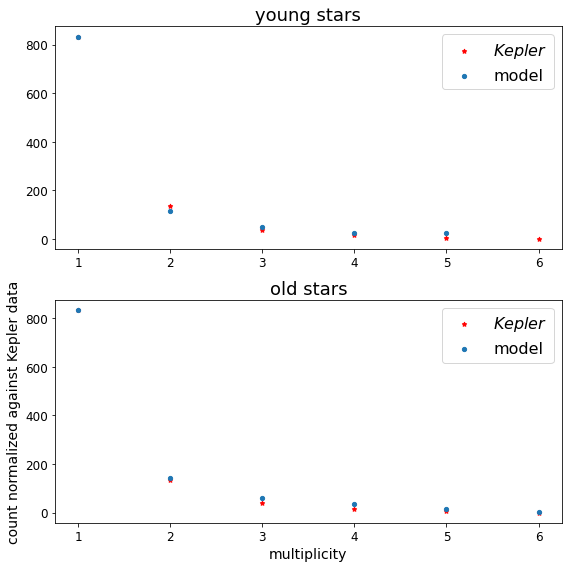

-33.93336405388279
-3249.8897920165427
-34.32442282027013
0.47867142571305016


In [295]:
df = pd.read_csv('transits9_4_5_0.csv')
print(df)
young = df.loc[df.iso_age <= 1]
old = df.loc[df.iso_age > 1]
print(len(young), len(old))
print(k[1:])

frac = 0.2
transiters_berger_kepler = df.loc[df['transit_status']==1]
transit_multiplicity = frac*transiters_berger_kepler.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
normalize = k[0]/transit_multiplicity[0]
print(transit_multiplicity)

transiters_berger_kepler_young = young.loc[young['transit_status']==1]
transit_multiplicity_young = frac*transiters_berger_kepler_young.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
normalize_young = k[0]/transit_multiplicity_young[0]
print(transit_multiplicity_young)

transiters_berger_kepler_old = old.loc[old['transit_status']==1]
transit_multiplicity_old = frac*transiters_berger_kepler_old.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
normalize_old = k[0]/transit_multiplicity_old[0]
print(transit_multiplicity_old)

"""
plt.scatter(np.arange(6)[1:], k[1:], marker=(5, 1), color='r', s=10)
plt.scatter(np.arange(7)[1:], normalize*transit_multiplicity, s=2)
plt.xlabel('multiplicity')
plt.ylabel('count normalized against Kepler data')
plt.title('all planets')
plt.show()
"""

fig, axes = plt.subplots(figsize=(8,8))
ax1 = plt.subplot2grid((2,1), (0,0))
#plt.figure()
#temp_k = [*k,0]
ax1.scatter(np.arange(7)[1:], k, marker=(5, 1), color='r', s=20, label=r'$Kepler$')
ax1.scatter(np.arange((len(transit_multiplicity_young)+1))[1:], normalize_young*transit_multiplicity_young, s=18, label='model')
#ax1.set_xlabel('multiplicity')
#ax1.set_ylabel('count normalized against Kepler data', fontsize=14)
ax1.set_title('young stars', fontsize=18)
ax1.tick_params(axis='both', labelsize=12)
ax1.legend(prop={'size': 16})

ax2 = plt.subplot2grid((2,1), (1,0))
ax2.scatter(np.arange(7)[1:], k, marker=(5, 1), color='r', s=20, label=r'$Kepler$')
ax2.scatter(np.arange((len(transit_multiplicity_old)+1))[1:], normalize_old*transit_multiplicity_old, s=18, label='model')
ax2.set_xlabel('multiplicity', fontsize=14)
ax2.set_ylabel('count normalized against Kepler data', fontsize=14)
ax2.set_title('old stars', fontsize=18)
ax2.tick_params(axis='both', labelsize=12)
ax2.legend(prop={'size': 16})

fig.tight_layout()
plt.savefig('young_v_old_best_model_incremental.eps', format='eps')
plt.show()

print(better_loglike(list(transit_multiplicity), list(k)))
print(better_loglike(list(transit_multiplicity_young), list(k)))
print(better_loglike(list(transit_multiplicity_old), list(k)))
print(len(df.loc[df.intact_flag=='intact'])/len(df))

In [ ]:
df = pd.read_csv('transits6_4_2_0.csv')
print(df)
young = df.loc[df.iso_age <= 1]
old = df.loc[df.iso_age > 1]
print(len(young), len(old))
print(k[1:])

frac = 0.2
transiters_berger_kepler = df.loc[df['transit_status']==1]
transit_multiplicity = frac*transiters_berger_kepler.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
normalize = k[0]/transit_multiplicity[0]
print(transit_multiplicity)

transiters_berger_kepler_young = young.loc[young['transit_status']==1]
transit_multiplicity_young = frac*transiters_berger_kepler_young.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
normalize_young = k[0]/transit_multiplicity_young[0]
print(transit_multiplicity_young)

transiters_berger_kepler_old = old.loc[old['transit_status']==1]
transit_multiplicity_old = frac*transiters_berger_kepler_old.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
normalize_old = k[0]/transit_multiplicity_old[0]
print(transit_multiplicity_old)

"""
plt.scatter(np.arange(6)[1:], k[1:], marker=(5, 1), color='r', s=10)
plt.scatter(np.arange(7)[1:], normalize*transit_multiplicity, s=2)
plt.xlabel('multiplicity')
plt.ylabel('count normalized against Kepler data')
plt.title('all planets')
plt.show()
"""

fig, axes = plt.subplots(figsize=(8,8))
ax1 = plt.subplot2grid((2,1), (0,0))
#plt.figure()
#temp_k = [*k,0]
ax1.scatter(np.arange(7)[1:], k, marker=(5, 1), color='r', s=20, label=r'$Kepler$')
ax1.scatter(np.arange(5)[1:], normalize_young*transit_multiplicity_young, s=18, label='model')
#ax1.set_xlabel('multiplicity')
#ax1.set_ylabel('count normalized against Kepler data', fontsize=14)
ax1.set_title('young planets', fontsize=18)
ax1.tick_params(axis='both', labelsize=12)
ax1.legend(prop={'size': 16})

ax2 = plt.subplot2grid((2,1), (1,0))
ax2.scatter(np.arange(7)[1:], k, marker=(5, 1), color='r', s=20, label=r'$Kepler$')
ax2.scatter(np.arange(7)[1:], normalize_old*transit_multiplicity_old, s=18, label='model')
ax2.set_xlabel('multiplicity', fontsize=14)
ax2.set_ylabel('count normalized against Kepler data', fontsize=14)
ax2.set_title('old planets', fontsize=18)
ax2.tick_params(axis='both', labelsize=12)
ax2.legend(prop={'size': 16})

fig.tight_layout()
plt.savefig('young_v_old_best_model.eps', format='eps')
plt.show()

print(better_loglike(list(transit_multiplicity), list(k)))
print(better_loglike(list(transit_multiplicity_young), list(k)))
print(better_loglike(list(transit_multiplicity_old), list(k)))
print(len(df.loc[df.intact_flag=='intact'])/len(df))

### AMD plot

One AMD value per system, so I'll plot the system's AMD at (mean(ecc), mean(incl)).

In [77]:
G = 6.6743e-8 # gravitational constant in cgs
calculate_amd([earth_mass_to_cgs(5.), earth_mass_to_cgs(5.)],
              [solar_mass_to_cgs(1.), solar_mass_to_cgs(1.)],
              [au_to_cgs(1.), au_to_cgs(2.)],
              [0.01, 0.01], [2*180/np.pi, 2*180/np.pi], 2)

TypeError: can't multiply sequence by non-int of type 'float'

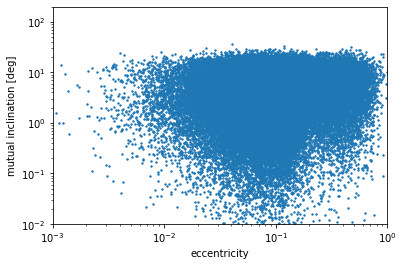

In [68]:
def calculate_amd(m_pks, m_star, a_ks, e_ks, i_ks, multiplicity):
    ### 
    # calculate angular momentum deficit following Eqn 13 from Milholland et al 2021
    ###
    amd = []
    for i in range(multiplicity):
        lambda_k = m_pks[i] * np.sqrt(G*m_star*a_ks[i])
        second_term = 1 - (np.sqrt(1 - (e_ks[i])**2))*np.cos(i_ks[i])
        amd.append(lambda_k * second_term)
        
    return np.sum(amd)

def earth_mass_to_cgs(mass):
    return mass*5.974e27 # grams

def solar_mass_to_cgs(mass):
    return mass*1.989e33 # grams

def au_to_cgs(distance):
    return distance*1.496e13 # cm

m_planet = 5. # 5 Earth masses roughly corresponds to 2 Earth radii, per Chen & Kipping

"""
# calculate AMD per system
amd = calculate_amd(earth_mass_to_cgs(m_planet), solar_mass_to_cgs(m_star), 
    [au_to_cgs(pac2_elt) for pac2_elt in planets_a_case2], eccentricity, 
    inclinations, num_planets)
amds.append(amd)
"""

plt.scatter(df.ecc, df.mutual_incl*180/np.pi, s=2)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-3,1e0)
plt.ylim(1e-2,2e2)
plt.xlabel('eccentricity')
plt.ylabel('mutual inclination [deg]')
plt.show()

In [75]:
def p_to_a(P, star_mass):
    """
    Newton's full version of Kepler's Third Law, assuming planet mass m --> 0
    Params: 
    - P: days
    - star_mass: Solar masses
    """

    P = P*86400 # days to seconds
    star_mass = star_mass*1.989e30 # solar mass to kg
    a_in_meters = (((P**2) * 6.67e-11 * star_mass)/(4*np.pi**2))**(1./3) # SI units(!)
    a = a_in_meters/(1.496e11) # meters to AU
    return a # in AU

def calculate_amd_array(df, m_pks, m_star, a_ks, e_ks, i_ks, multiplicity):
    ### 
    # calculate angular momentum deficit following Eqn 13 from Milholland et al 2021
    ###
    
    G = 6.6743e-8 # gravitational constant in cgs

    amds = []
    sys_ids = df.kepid.unique()
    for sys_id in sys_ids:
        # for each system
        system = df.loc[df.kepid == sys_id]
        print(system)

        # get mean ecc and incl
        #mean_ecc = np.mean(system.ecc)
        #mean_incl = np.mean(system.incl)
        
        # get system-level variables to constant form
        #sys_mass = df
        
        lambda_ks = m_pks * np.sqrt(G*m_star*a_ks)
        second_terms = 1 - (np.sqrt(1 - (e_ks)**2))*np.cos(i_ks)
        print(lambda_ks)
        print(second_terms)

        amd.append(lambda_k * second_term)
        
    return np.sum(amd)

m_planet = earth_mass_to_cgs(5.)
a_s = p_to_a(df.P, df.iso_mass)
amds = calculate_amd_array(df, m_planet, df.iso_mass, a_s, df.ecc, df.incl, df.num_planets)
print(amds)

   Unnamed: 0   kepid           tm_designation  teff  teff_err1  teff_err2  \
0           0  757280  2MASS J19242289+3633538  6543      162.0     -194.0   
1           0  757280  2MASS J19242289+3633538  6543      162.0     -194.0   

    logg  logg_err1  logg_err2  feh_x  ...  intact_flag  num_planets  \
0  4.082      0.258     -0.172  -0.24  ...    disrupted            2   
1  4.082      0.258     -0.172  -0.24  ...    disrupted            2   

        ecc      incl     omega  planet_radius  mutual_incl  transit_status  \
0  0.086055  0.496742  1.135532            2.0    -0.092121               0   
1  0.089793  0.054348  5.501752            2.0     0.350272               0   

   prob_detections   sn  
0              0.0  0.0  
1              0.0  0.0  

[2 rows x 156 columns]
0         3.749743e+24
1         5.722424e+24
2         2.409837e+24
3         2.793267e+24
4         2.530315e+24
              ...     
126855    7.772043e+24
126856    3.872476e+24
126857    1.659385e+24
1

/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


NameError: name 'adfadf' is not defined

In [60]:
df.groupby('kepid').mean('ecc')

,Unnamed: 0,teff,teff_err1,teff_err2,logg,logg_err1,logg_err2,feh_x,feh_err1,feh_err2,...,P,num_planets,ecc,incl,omega,planet_radius,mutual_incl,transit_status,prob_detections,sn
kepid,,,,,,,,,,,,,,,,,,,,,
757280,0.0,6543.0,162.0,-194.0,4.082,0.258,-0.172,-0.24,0.25,-0.30,...,32.450581,2.0,0.087924,0.275545,3.318642,2.0,0.129076,0.0,0.0,0.0
892195,1.0,5522.0,194.0,-155.0,3.984,0.510,-0.170,-0.06,0.30,-0.25,...,14.973301,1.0,0.371028,-0.255088,3.989879,2.0,-0.208703,0.0,0.0,0.0
892667,2.0,6609.0,159.0,-227.0,4.105,0.246,-0.164,-0.26,0.25,-0.30,...,6.302544,2.0,0.094607,0.191399,2.988736,2.0,0.080496,0.0,0.0,0.0
892678,3.0,6137.0,167.0,-186.0,3.936,0.428,-0.143,-0.26,0.30,-0.30,...,36.758715,6.0,0.079463,0.443326,2.660679,2.0,0.048821,0.0,0.0,0.0
892713,4.0,6106.0,186.0,-186.0,3.854,0.496,-0.124,-0.24,0.30,-0.30,...,132.649398,2.0,0.068143,-0.309143,2.456354,2.0,0.336475,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12935035,67375.0,6071.0,192.0,-234.0,3.992,0.382,-0.127,-0.06,0.25,-0.30,...,54.106747,1.0,0.198305,-0.117075,3.838655,2.0,0.176388,0.0,0.0,0.0
12983952,67376.0,5365.0,175.0,-191.0,4.571,0.032,-0.136,0.12,0.25,-0.30,...,69.485208,2.0,0.065440,-0.327143,2.007197,2.0,-0.042995,0.0,0.0,0.0
12984000,67377.0,5835.0,174.0,-192.0,4.464,0.084,-0.196,-0.26,0.30,-0.30,...,63.988243,5.0,0.066461,-0.970327,4.147500,2.0,-0.010258,0.0,0.0,0.0


In [62]:
df.loc[df.kepid==757280]

,Unnamed: 0,kepid,tm_designation,teff,teff_err1,teff_err2,logg,logg_err1,logg_err2,feh_x,...,intact_flag,num_planets,ecc,incl,omega,planet_radius,mutual_incl,transit_status,prob_detections,sn
0,0,757280,2MASS J19242289+3633538,6543,162.0,-194.0,4.082,0.258,-0.172,-0.24,...,disrupted,2,0.086055,0.496742,1.135532,2.0,-0.092121,0,0.0,0.0
1,0,757280,2MASS J19242289+3633538,6543,162.0,-194.0,4.082,0.258,-0.172,-0.24,...,disrupted,2,0.089793,0.054348,5.501752,2.0,0.350272,0,0.0,0.0


#### Young vs old, looking for cutoff timescales that lead to young and old transit multiplicities being same or different

/Users/chrislam/opt/anaconda3/envs/sculpting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (139) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


        Unnamed: 0     kepid           tm_designation  teff  teff_err1  \
0                0    757280  2MASS J19242289+3633538  6543      162.0   
1                1    892195  2MASS J19240520+3638374  5522      194.0   
2                2    892667  2MASS J19243045+3637186  6609      159.0   
3                3    892678  2MASS J19243108+3638316  6137      167.0   
4                4    892713  2MASS J19243353+3637220  6106      186.0   
...            ...       ...                      ...   ...        ...   
102187       67377  12984000  2MASS J19194837+5225067  5835      174.0   
102188       67377  12984000  2MASS J19194837+5225067  5835      174.0   
102189       67378  12984200  2MASS J19201625+5224552  5862      161.0   
102190       67379  12984307  2MASS J19202959+5228286  5802      205.0   
102191       67379  12984307  2MASS J19202959+5228286  5802      205.0   

        teff_err2   logg  logg_err1  logg_err2  feh_x  ...  intact_flag  \
0          -194.0  4.082      0.258 

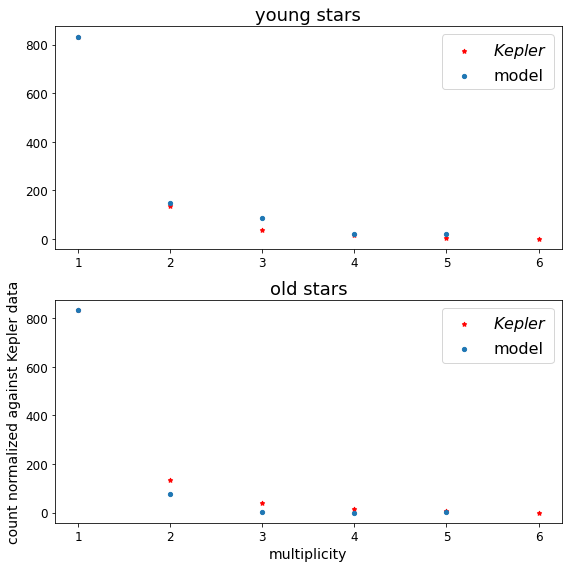

-155.9370520646761
-3729.4644178994004
-189.77594127143848
0.015832941913261313


In [237]:
df = pd.read_csv('transits8_5_7_0.csv')
print(df)
young = df.loc[df.iso_age <= 1]
old = df.loc[df.iso_age > 1]
print(len(young), len(old))
print(k[1:])

frac = 0.2
transiters_berger_kepler = df.loc[df['transit_status']==1]
transit_multiplicity = frac*transiters_berger_kepler.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
normalize = k[0]/transit_multiplicity[0]
print(transit_multiplicity)

transiters_berger_kepler_young = young.loc[young['transit_status']==1]
transit_multiplicity_young = frac*transiters_berger_kepler_young.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
normalize_young = k[0]/transit_multiplicity_young[0]
print(transit_multiplicity_young)

transiters_berger_kepler_old = old.loc[old['transit_status']==1]
transit_multiplicity_old = frac*transiters_berger_kepler_old.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
normalize_old = k[0]/transit_multiplicity_old[0]
print(transit_multiplicity_old)

"""
plt.scatter(np.arange(6)[1:], k[1:], marker=(5, 1), color='r', s=10)
plt.scatter(np.arange(7)[1:], normalize*transit_multiplicity, s=2)
plt.xlabel('multiplicity')
plt.ylabel('count normalized against Kepler data')
plt.title('all planets')
plt.show()
"""

fig, axes = plt.subplots(figsize=(8,8))
ax1 = plt.subplot2grid((2,1), (0,0))
#plt.figure()
#temp_k = [*k,0]
ax1.scatter(np.arange(7)[1:], k, marker=(5, 1), color='r', s=20, label=r'$Kepler$')
ax1.scatter(np.arange(len(transit_multiplicity_young)+1)[1:], normalize_young*transit_multiplicity_young, s=18, label='model')
#ax1.set_xlabel('multiplicity')
#ax1.set_ylabel('count normalized against Kepler data', fontsize=14)
ax1.set_title('young stars', fontsize=18)
ax1.tick_params(axis='both', labelsize=12)
ax1.legend(prop={'size': 16})

ax2 = plt.subplot2grid((2,1), (1,0))
ax2.scatter(np.arange(7)[1:], k, marker=(5, 1), color='r', s=20, label=r'$Kepler$')
ax2.scatter(np.arange(len(transit_multiplicity_old)+1)[1:], normalize_old*transit_multiplicity_old, s=18, label='model')
ax2.set_xlabel('multiplicity', fontsize=14)
ax2.set_ylabel('count normalized against Kepler data', fontsize=14)
ax2.set_title('old stars', fontsize=18)
ax2.tick_params(axis='both', labelsize=12)
ax2.legend(prop={'size': 16})

fig.tight_layout()
#plt.savefig('young_v_old_best_model.eps', format='eps')
plt.show()

print(better_loglike(list(transit_multiplicity), list(k)))
print(better_loglike(list(transit_multiplicity_young), list(k)))
print(better_loglike(list(transit_multiplicity_old), list(k)))
print(len(df.loc[df.intact_flag=='intact'])/len(df))

In [259]:
df_logLs = pd.read_csv('logLs_incremental.txt', )
print(df_logLs)

       m    b            c    f         logL  transit_multiplicity  \
0   -2.0  0.0  100000000.0  0.0 -5298.913593                  [0.0   
1   -2.0  0.0  100000000.0  0.0 -5298.913593                  [0.0   
2   -2.0  0.0  100000000.0  0.0 -5298.913593                  [0.0   
3   -2.0  0.0  100000000.0  0.0 -5298.913593                  [0.0   
4   -2.0  0.0  100000000.0  0.0 -5298.913593                  [0.0   
..   ...  ...          ...  ...          ...                   ...   
104 -2.0  0.0  100000000.0  1.0 -2074.070045               [4077.0   
105 -2.0  0.0  100000000.0  1.0 -1966.455531               [3962.0   
106 -2.0  0.0  100000000.0  1.0 -2076.499494               [4087.0   
107 -2.0  0.0  100000000.0  1.0 -2065.757988               [4104.0   
108 -2.0  0.0  100000000.0  1.0 -2059.298942               [4109.0   

     intact_frac   disrupted_frac-2.0      0.0  100000000.0  0.0.1  \
0           0.0]                  0.0  0.00000          NaN    NaN   
1           0.0]   